# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [31]:
#! pip install yfinance pandas numpy matplotlib lightgbm torch tensorflow keras

### Importing Required Libraries

In [32]:
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

### Variables

In [33]:
print_errors = False
build_new_dataset = True
symbol_list = 'advanced' # 'simple' or 'advanced'. simple are the tickers from the screener notebook and advanced are all of the tickers in 'filtered_tickers'

## Data Preparation

In [34]:
if symbol_list == 'simple':
    symbols = pd.read_csv('../data/simple_screener_results.csv')['Ticker'].tolist()
if symbol_list == 'advanced':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['A', 'AA', 'AAT', ..., 'ZEUS', 'ZION', 'ZUMZ'], dtype=object)

#### Download annual financial data

In [ ]:
if build_new_dataset:
    df = pd.DataFrame()
    for symbol in tqdm(symbols):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        try:
            # Latest earning data
            latest_earning_date = ticker.quarterly_cash_flow.columns.tolist()[0]
            latest_data = {'Ticker': symbol, 'Date': latest_earning_date}
            latest_data['3M Future Change'] = np.nan
            latest_data['6M Future Change'] = np.nan
            latest_data['1Y Future Change'] = np.nan

            try:
                latest_data['Sector'] = ticker.info['sector']
            except:
                latest_data['Sector'] = 'Unknown'
                
            try:
                latest_data['Industry'] = ticker.info['industry']
            except:
                latest_data['Industry'] = 'Unknown'

            for column in ticker.quarterly_cash_flow[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_cash_flow[latest_earning_date][column]

            for column in ticker.quarterly_balance_sheet[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_balance_sheet[latest_earning_date][column]

            for column in ticker.quarterly_income_stmt[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_income_stmt[latest_earning_date][column]

            ticker_df = pd.concat([ticker_df, pd.DataFrame([latest_data])], ignore_index=True)

            # Annual data
            earning_dates = ticker.cash_flow.columns.tolist()
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()
            for earning_date in earning_dates:
                earning_date_data = {'Ticker': symbol, 'Date': earning_date}
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:           
                        earning_date_data['3M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=13) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['6M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=26) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['1Y Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=52) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        got_price = True
                    except:
                        day_offset += -1

                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'

                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]

                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]

                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

            if len(ticker_df) != 5:
                continue

            imputer = SimpleImputer()
            for column in ticker_df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
                if not ticker_df[column].isna().all():
                    ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if print_errors:
                print(f'Error for {symbol}: {error}')
            continue

    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

 30%|███       | 476/1563 [14:30<39:05,  2.16s/it] 

### Short visualisation

In [ ]:
df

,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Dueto Related Parties Current,Restricted Cash,Duefrom Related Parties Current,Short Term Debt Issuance,Commercial Paper,Preferred Stock,Line Of Credit,Average Dilution Earnings,Preferred Securities Outside Stock Equity,Interest Payable
0,MATAS.CO,2024-12-31,NaN,NaN,NaN,Consumer Cyclical,Specialty Retail,3.770000e+08,-2.700000e+07,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MATAS.CO,2024-03-31,0.006267,0.065357,0.159205,Consumer Cyclical,Specialty Retail,2.390000e+08,-2.100000e+07,-1.890000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MATAS.CO,2023-03-31,0.014033,0.205079,0.459568,Consumer Cyclical,Specialty Retail,4.240000e+08,0.000000e+00,-1.260000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MATAS.CO,2022-03-31,-0.211179,-0.301726,-0.110513,Consumer Cyclical,Specialty Retail,3.271000e+08,-7.510000e+07,-7.084000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MATAS.CO,2021-03-31,0.391748,0.478732,0.209816,Consumer Cyclical,Specialty Retail,8.036000e+08,0.000000e+00,-7.250000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,RNMBY,2024-12-31,NaN,NaN,NaN,Industrials,Aerospace & Defense,9.110000e+08,NaN,-3.160000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,RNMBY,2023-12-31,0.768973,0.616452,1.071535,Industrials,Aerospace & Defense,3.450000e+08,NaN,-4.850000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,RNMBY,2022-12-31,0.493045,0.398488,0.633525,Industrials,Aerospace & Defense,-1.750000e+08,NaN,-2.320000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,RNMBY,2021-12-31,1.329688,1.491433,1.219995,Industrials,Aerospace & Defense,4.190000e+08,NaN,-2.310000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,RNMBY,2020-12-31,-0.075638,-0.041881,-0.106959,Industrials,Aerospace & Defense,3.750000e+08,NaN,-3.160000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Impution and encoding

In [ ]:
for column in df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
    df[column] = imputer.fit_transform(df[[column]])
    scaler = StandardScaler()
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

le = LabelEncoder()
for column in ['Sector', 'Industry']:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Splitting

In [ ]:
pred_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    pred_data = pd.concat([pred_data, df.iloc[[i*5]]]) 
print('Prediction Data:')
display(pred_data)

train_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    train_data = pd.concat([train_data, df.iloc[[1+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[2+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[3+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[4+i*5]]])
print('Train and Test Data:')
display(train_data)

Prediction Data:


,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Dueto Related Parties Current,Restricted Cash,Duefrom Related Parties Current,Short Term Debt Issuance,Commercial Paper,Preferred Stock,Line Of Credit,Average Dilution Earnings,Preferred Securities Outside Stock Equity,Interest Payable
0,MATAS.CO,2024-12-31,NaN,NaN,NaN,0,6,-0.570652,0.784309,0.546522,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,RNMBY,2024-12-31,NaN,NaN,NaN,3,0,-0.477951,0.000000,0.419958,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,SAABF,2024-12-31,NaN,NaN,NaN,3,0,-0.046390,0.651261,0.504067,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,GMAB,2024-12-31,NaN,NaN,NaN,2,2,-0.200197,0.810788,0.546522,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,LLY,2024-12-31,NaN,NaN,NaN,2,3,-0.509962,-1.203468,0.546522,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,TER,2024-12-31,NaN,NaN,NaN,4,5,-0.597008,0.670037,0.546522,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,EQNR,2024-12-31,NaN,NaN,NaN,1,4,-0.848753,0.318477,0.194866,...,-3.204431,-1.365667,-3.165256,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,TSLA,2024-12-31,NaN,NaN,NaN,0,1,-0.283002,0.000000,0.223303,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Train and Test Data:


,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Dueto Related Parties Current,Restricted Cash,Duefrom Related Parties Current,Short Term Debt Issuance,Commercial Paper,Preferred Stock,Line Of Credit,Average Dilution Earnings,Preferred Securities Outside Stock Equity,Interest Payable
1,MATAS.CO,2024-03-31,0.006267,0.065357,0.159205,0,6,-0.594608,0.790193,0.470824,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
2,MATAS.CO,2023-03-31,0.014033,0.205079,0.459568,0,6,-0.562493,0.810788,0.496056,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,MATAS.CO,2022-03-31,-0.211179,-0.301726,-0.110513,0,6,-0.579314,0.737137,0.262794,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4,MATAS.CO,2021-03-31,0.391748,0.478732,0.209816,0,6,-0.496595,0.810788,0.256146,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
6,RNMBY,2023-12-31,0.768973,0.616452,1.071535,3,0,-0.576207,0.000000,0.352270,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
7,RNMBY,2022-12-31,0.493045,0.398488,0.633525,3,0,-0.666477,0.000000,0.453601,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
8,RNMBY,2021-12-31,1.329688,1.491433,1.219995,3,0,-0.563361,0.000000,0.454002,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
9,RNMBY,2020-12-31,-0.075638,-0.041881,-0.106959,3,0,-0.570999,0.000000,0.419958,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
11,SAABF,2023-12-31,0.498190,0.678304,0.559131,3,0,-0.128501,0.651261,0.115964,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
12,SAABF,2022-12-31,0.533624,0.443572,0.628164,3,0,-0.229187,0.810788,-0.008597,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000


### Labeling

In [ ]:
X_pred = pred_data.drop(['Date', 'Ticker', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
X_train = train_data.drop(['Date', 'Ticker', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
y_train = train_data[['3M Future Change', '6M Future Change', '1Y Future Change']]

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    shuffle=True,
)

display(X_train)
display(y_train)
display(X_test)
display(y_test)

,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Issuance Of Capital Stock,Capital Expenditure,End Cash Position,Other Cash Adjustment Outside Changein Cash,...,Dueto Related Parties Current,Restricted Cash,Duefrom Related Parties Current,Short Term Debt Issuance,Commercial Paper,Preferred Stock,Line Of Credit,Average Dilution Earnings,Preferred Securities Outside Stock Equity,Interest Payable
39,0,1,0.120175,0.000000,-1.566513,1.050341e+00,5.570067,-1.269611,1.839469,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,4.472136,4.472136
14,3,0,-0.121471,0.573459,0.035360,-1.173625e-01,-0.506370,0.060381,-0.568652,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
9,3,0,-0.570999,0.000000,0.419958,-4.085982e-01,0.000000,0.740098,-0.805547,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
29,4,5,-0.547940,0.346711,0.500461,-7.312035e-01,0.000000,0.804744,-0.820704,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
26,4,5,-0.562217,0.421214,0.526390,-7.312035e-01,0.000000,0.794839,-0.831086,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
36,0,1,0.120262,0.000000,-0.180419,1.241821e+00,1.519109,-1.956884,1.817787,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,-3.021989,0.000000,0.000000
22,2,3,0.162516,-0.660260,-0.078287,-7.312035e-01,0.000000,-0.094863,-0.619996,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4,0,6,-0.496595,0.810788,0.256146,-7.312035e-01,-0.506370,0.798379,-0.946652,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
7,3,0,-0.666477,0.000000,0.453601,-6.062269e-01,0.000000,0.735217,-0.861647,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
12,3,0,-0.229187,0.810788,-0.008597,-3.153515e-02,-0.506370,0.117766,-0.490708,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000


,3M Future Change,6M Future Change,1Y Future Change
39,-0.062239,-0.039324,0.516771
14,-0.002849,-0.058484,0.041659
9,-0.075638,-0.041881,-0.106959
29,0.075173,0.080778,0.369665
26,0.022849,0.338933,0.189582
36,-0.305672,-0.220239,0.793704
22,-0.058247,0.289419,0.609091
4,0.391748,0.478732,0.209816
7,0.493045,0.398488,0.633525
12,0.533624,0.443572,0.628164


,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Issuance Of Capital Stock,Capital Expenditure,End Cash Position,Other Cash Adjustment Outside Changein Cash,...,Dueto Related Parties Current,Restricted Cash,Duefrom Related Parties Current,Short Term Debt Issuance,Commercial Paper,Preferred Stock,Line Of Credit,Average Dilution Earnings,Preferred Securities Outside Stock Equity,Interest Payable
28,4,5,-0.468422,0.222369,0.409148,-7.312035e-01,0.00000,0.803394,-0.772306,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
18,2,2,-0.293071,0.372416,0.523291,1.196657e-16,-0.50637,0.765759,0.490725,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0,6,-0.579314,0.737137,0.262794,-3.479920e-01,-0.50637,0.787359,-0.948667,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
27,4,5,-0.564112,0.073222,0.519783,-7.312035e-01,0.00000,0.793704,-0.815417,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
34,1,4,1.970236,-1.574025,-0.519558,3.458274e+00,0.00000,-1.596599,0.954157,0.0,...,0.0,0.0,0.0,0.0,-1.338291,0.0,0.0,0.0,0.0,0.0


,3M Future Change,6M Future Change,1Y Future Change
28,-0.287730,-0.474279,-0.463481
18,-0.073812,-0.154955,0.071284
3,-0.211179,-0.301726,-0.110513
27,0.232045,0.277258,0.247781
34,0.206500,0.312575,0.667386


## Model Training

In [ ]:
base_model = MLPRegressor()

param_grid = {
    'shuffle': [True], 
    'solver': ['adam'], 
    'learning_rate': ['adaptive'],
    'tol': [0.0001],
    'max_iter': [200],
    'alpha': [0.00025, 0.0001],
    'hidden_layer_sizes': [(300, 300, 300), (400, 400, 400), (500, 500, 500)],
    'learning_rate_init': [0.001, 0.00075],
    'n_iter_no_change': [4, 6, 9,]
}

grid_search = GridSearchCV(
    estimator=base_model, 
    param_grid=param_grid, 
    scoring='r2', 
    cv=3, 
    n_jobs=-1,
    verbose=1,
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
model = grid_search.best_estimator_
print('Best Parameters:')
print(best_params)

model.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters:
{'alpha': 0.0001, 'hidden_layer_sizes': (500, 500, 500), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 4, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001}


MLPRegressor(hidden_layer_sizes=(500, 500, 500), learning_rate='adaptive',
             n_iter_no_change=4)

## Testing and benchmarking

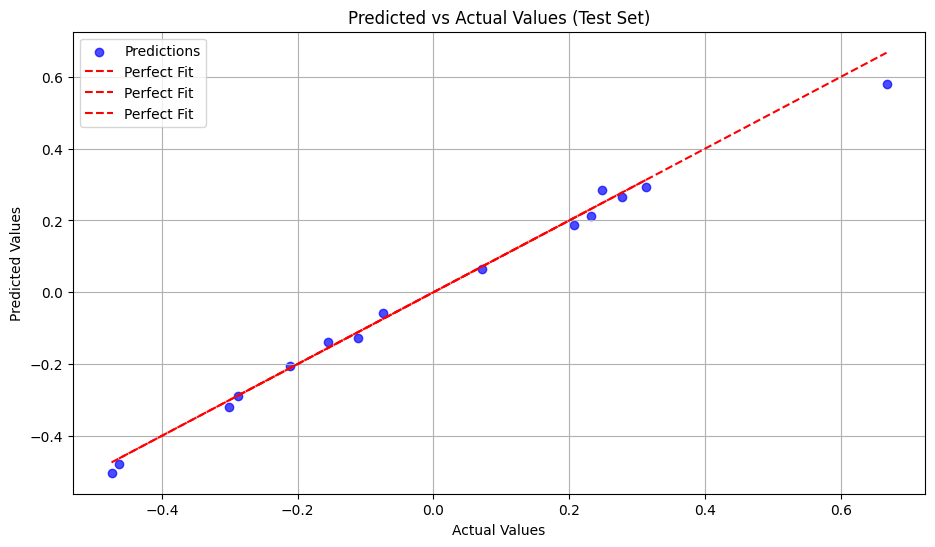

R²: 0.9927
MSE: 0.0008
MAE: 0.0211


In [ ]:
y_test_pred = model.predict(X_test)

for i, target in enumerate(['3M Future Change', '6M Future Change', '1Y Future Change']):
    y_test_actual = y_test[target]
    y_test_pred_target = y_test_pred[:, i]

    plt.figure(figsize=(11, 6))
    plt.scatter(y_test_actual, y_test_pred_target, alpha=0.7, color='blue', label='Predictions')
    plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 
        color='red', linestyle='--', label='Perfect Fit')
    plt.title(f'Predicted vs Actual Values ({target})')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    mae = mean_absolute_error(y_test_actual, y_test_pred_target)
    mse = mean_squared_error(y_test_actual, y_test_pred_target)
    r2 = r2_score(y_test_actual, y_test_pred_target)

    print(f'{target} - R²: {r2:.4f}')
    print(f'{target} - MSE: {mse:.4f}')
    print(f'{target} - MAE: {mae:.4f}')

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print('\nOverall Scores:')
print(f'Mean - R²: {r2:.4f}')
print(f'Mean - MSE: {mse:.4f}')
print(f'Mean - MAE: {mae:.4f}')

### Log test results

In [ ]:
test_results = pd.DataFrame({
    'R²': r2,
    'MSE': mse,
    'MAE': mae,
    'symbol_list': symbol_list,
    'hidden_layer_sizes': [model.hidden_layer_sizes],
    'max_iter': model.max_iter,
    'n_iter_no_change': model.n_iter_no_change,
    'learning_rate': model.learning_rate,
    'learning_rate_init': model.learning_rate_init,
    'batch_size': model.batch_size,
    'tol': model.tol,
    'alpha': model.alpha,
    'shuffle': model.shuffle,
})
test_results.to_csv('../data/test_results.csv', mode='a', index=False)

NameError: name 'symbol_list' is not defined

## Predictions on latest data